In [198]:
%load_ext autoreload
%autoreload 2

from src.models.wifi_model import WifiModel
from src.data.datasets import FloorDataset
from src.utils import object_to_markdown, get_best_trial
from src.plotting import *


from IPython.display import display,Image

import seaborn as sns
import matplotlib.pyplot as plt
import torch

#site_id = "5d2709b303f801723c327472"
#floor_id = "1F"

site_id = "5a0546857ecc773753327266"
floor_id = "B1"

floor_data = FloorDataset(site_id, floor_id, wifi_threshold=200, sampling_interval=100, include_wifi=True, include_beacon=False,        validation_percent=0.3,
        test_percent=0.2)
floor_image = floor_data.image
floor_height = floor_data.info["map_info"]["height"]
floor_width = floor_data.info["map_info"]["width"]

sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wifi Model

In the wifi model, we are extending the inital model to include the wifi signals of the model. We now deal with $K$ wifi signals, which corresponds to $K$ latent wifi router location parameters $\boldsymbol{\ell}_k \sim \mathcal{Floor}(width, hight)$ and $K$ latent wifi router strenghts $\omega_k^0 \sim \mathcal{N}(\mu_{\omega_0}, \sigma_{\omega_0})$,i.e. wifi strength 1 meter away from the router). And there is now potentially $T\cdot K$ observed wifi signal strenghts $$\omega_{t,k} \sim \mathcal{N}(\omega^0_k - 2 ||\boldsymbol x_t- \boldsymbol \ell_k||, \sigma_\omega),$$but in fact they are quite seldom observed. $\omega_{t,k}$ can now make infomation flow between the new latent wifi variabels and $\boldsymbol x$ and $\boldsymbol {\hat x}$, thereby the Wifi model is our first model that can participate in the Kaggle Competition, since it can make preditions of the latent location $x$ based on measured wifi and inferede wifi latent variabels. We have defined a training and test data set to evaluate the models predicitve power. 

We have implemented the model in `src/models/wifi_model.py` as a method of the `WifiModel` class which also holds various model attributes and the variational parameters. 
The extended PGM and corresponding source code of the generative model can be seen below:

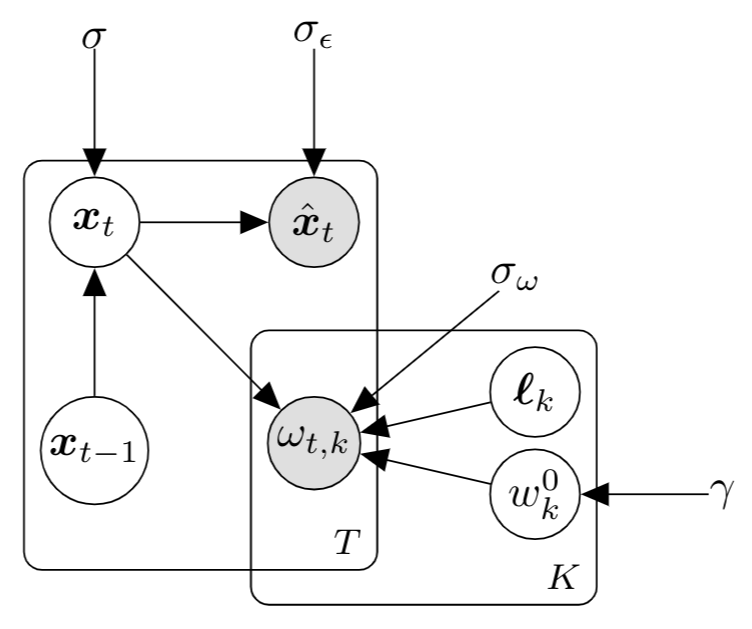

In [165]:
Image(filename='wifi_model.png', width = 300) 

In [33]:
display(object_to_markdown(WifiModel.model))

```python
def model(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    annealing_factor=1.0,
):

    pyro.module("wifi_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K

    relaxed_floor_dist = dist.Normal(
        self.floor_uniform.mean, self.floor_uniform.stddev
    ).to_event(1)

    sigma_eps = torch.tensor(self.prior_params["sigma_eps"], device=device)
    sigma = torch.tensor(self.prior_params["sigma"], device=device)
    mu_omega_0 = torch.tensor(self.prior_params["mu_omega_0"], device=device)
    sigma_omega_0 = torch.tensor(self.prior_params["sigma_omega_0"], device=device)
    sigma_omega = torch.tensor(self.prior_params["sigma_omega"], device=device)

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            x_0 = sample("x_0", relaxed_floor_dist)
            x = torch.zeros(
                x_0.shape[:-1] + (T_max,) + x_0.shape[-1:],  # Batch dims, time, x/y
                dtype=mini_batch_position.dtype,
                device=device,
            )
            x[..., 0, :] = x_0

            for t in pyro.markov(range(1, T_max)):
                x[..., t, :] = sample(
                    f"x_{t}",
                    dist.Normal(x[..., t - 1, :], sigma_eps)
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

    with pyro.plate("x_observed", mini_batch_position_mask.sum()):
        sample(
            "x_hat",
            dist.Normal(x[..., mini_batch_position_mask, :], sigma).to_event(1),
            obs=mini_batch_position[mini_batch_position_mask],
        )

    any_wifi_is_observed = mini_batch_wifi_mask.any(dim=-1)

    with plate("wifis", K):

        with poutine.scale(None, annealing_factor):
            omega_0 = sample("omega_0", dist.Normal(mu_omega_0, sigma_omega_0))
            wifi_location = sample("wifi_location", relaxed_floor_dist)

        distance = torch.cdist(x[..., any_wifi_is_observed, :], wifi_location)
        with plate("wifi_is_observed", any_wifi_is_observed.sum()):
            signal_strength = omega_0 - 2 * torch.log(distance)
            omega = sample(
                "omega",
                dist.Normal(signal_strength, sigma_omega).mask(
                    mini_batch_wifi_mask[any_wifi_is_observed]
                ),
                obs=mini_batch_wifi[any_wifi_is_observed],
            )

    return x, wifi_location
```

We have patitioned the data into a test and training set. (also validation, however, this is omitted for now). The test set consists of $15\%$ of the 109 traces

In [177]:
train_indices = (~floor_data.test_mask & ~floor_data.validation_mask).nonzero().flatten()
validation_indices = floor_data.validation_mask.nonzero().flatten()
[2,5,10,20, 30]
mini_batch_train = floor_data[train_indices[1:7]]
mini_batch_validation = floor_data[validation_indices[1:7]]

In [178]:
torch.manual_seed(123)
wifi_model = WifiModel(floor_data)

In [179]:
x, wifi_location = wifi_model.model(*mini_batch_train)

The wifi router location is distributed using a relaxed floor distribution, i.e. week normal distribution close to a uniform distribtion on the floor $U([0, width_{floor}], [0,height_{floor}])$. this is used in order to match the domain of the guide function. Below is the model, with simple random walks of the trace data and weakly normal distribtruion of the wifi router locations. 

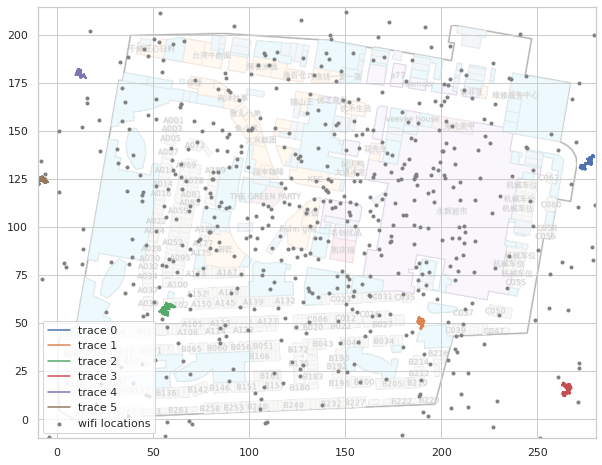

In [188]:
plt.figure(figsize=(10,10))
plt.scatter(*wifi_location.T, marker=".", color="grey", label="wifi locations")
plt.plot(*x.T, label=[f"trace {i}" for i in range(x.shape[0])])
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha = 0.3)
plt.xlim(-10,floor_width+10)
plt.ylim(-10,floor_height+10)

plt.legend()
plt.show()

As for the inital model, we used amotized variational inference for inference on $\boldsymbol x$, and we used a mean field approximation for the other variational distributions eg. wifi locations and signal strengths. The extended guide function is seen below:

In [34]:
display(object_to_markdown(WifiModel.guide))

```python
def guide(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    annealing_factor=1.0,
):

    pyro.module("wifi_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K

    location = torch.zeros((len(mini_batch_index), T_max, 2), device=device)
    scale = torch.zeros((len(mini_batch_index),), device=device)

    for i, (index, length) in enumerate(zip(mini_batch_index, mini_batch_length)):
        l, s = self.trace_guides[index](mini_batch_time[i, :length].unsqueeze(1))
        location[i, :length, :] = l
        scale[i] = s

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            for t in pyro.markov(range(0, T_max)):
                sample(
                    f"x_{t}",
                    dist.Normal(location[:, t, :], scale.view(-1, 1))
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

        with plate("wifis", K):
            sample("omega_0", dist.Normal(self.mu_q, self.log_sigma_q.exp()))
            sample(
                "wifi_location",
                dist.Normal(
                    self.wifi_location_q, self.wifi_location_log_sigma_q.exp()
                ).to_event(1),
            )

    return location, scale
```

**Mangler mere lækkert data** -> Hvordan virker denne?

In [203]:
get_best_trial("wifi")

KeyError: 'Record does not exist.'

## Model Training
Due to the size of the model / the number of parameters, the model is trained using the `src/models/wifi_models.py` script. This allowed us to easily use the DTU HPC cluster for training. Below, we load a checkpoint of the trained model

In [190]:
checkpoint = torch.load("../checkpoints/wifi_hparam_012.pt", map_location="cpu")
wifi_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

We can investigate the training loss over the course of training the model

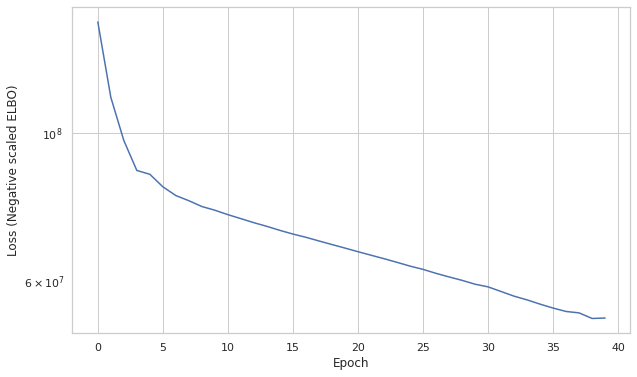

In [191]:
plt.figure(figsize=(10,6))
plt.plot(checkpoint["loss_history"])
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (Negative scaled ELBO)")

plt.show()

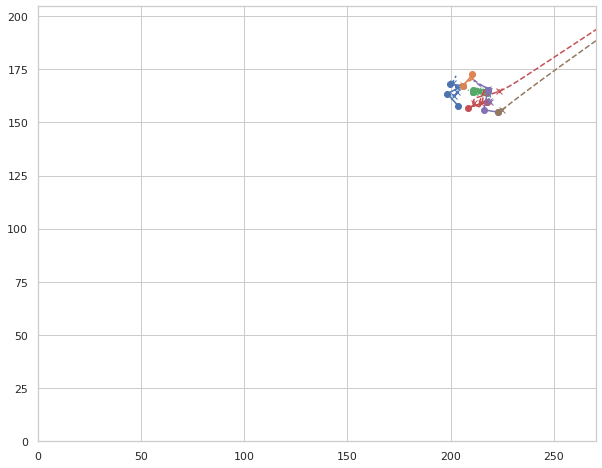

In [204]:
fig, ax = plt.subplots(figsize = (10,8))
plot_traces(wifi_model, mini_batch_train)
plt.xlim(0,floor_width)
plt.ylim(0,floor_height)
plt.show()

Wifi location represented in the guide function to be a normal distribution with diagoal covariance, the wifi location with 1 std eplises is plotted here, notice that some ot the wifi locations has very low variance while others have very high variance. This is probably do to low amount to data or bad initiallisation. 

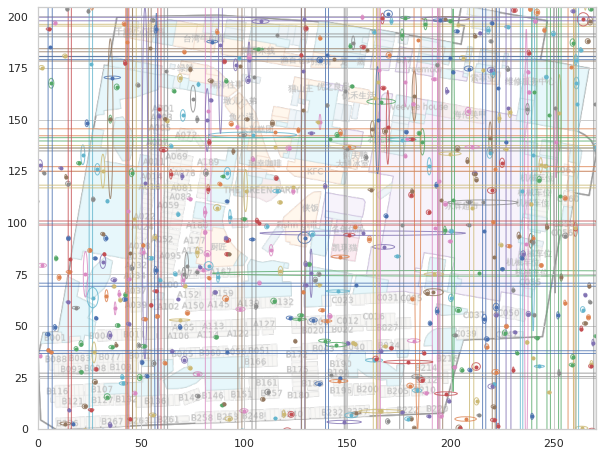

In [210]:
fig, ax = plt.subplots(figsize = (10,8))
wifi_ids = plot_wifi(wifi_model, ax = ax, scale_thresshold = 100000, alpha=1)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha = 0.4)
plt.xlim(0,floor_width)
plt.ylim(0,floor_height)
plt.show()

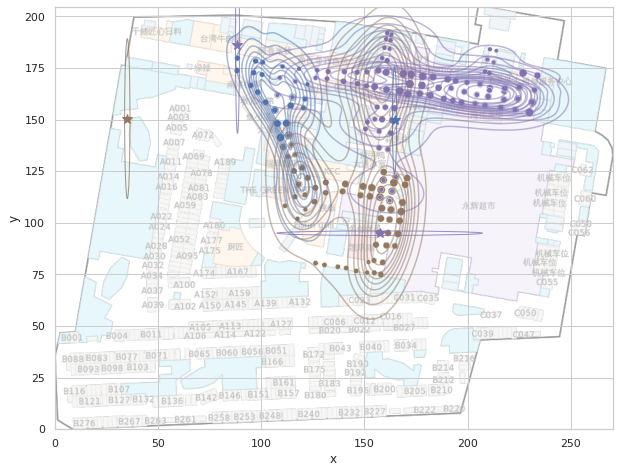

In [217]:
wifi_ids = get_wifi_ids(wifi_model, scale_threshold = 50).wifi_id
fig, ax = plt.subplots(figsize = (10,8))
plot_emperical_and_infered_wifi(wifi_model,floor_data, wifi_ids[-4:], ax = ax, with_scatter = True)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha = 0.4)

plt.xlim(0,floor_width)
plt.ylim(0,floor_height)
plt.show()

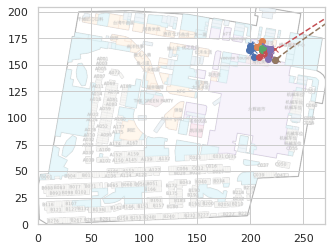

In [195]:
plot_traces(wifi_model, mini_batch_train)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha = 0.4)


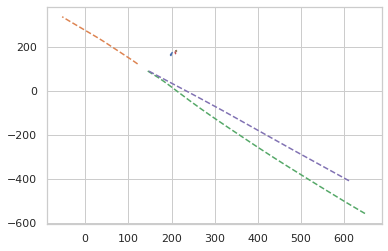

In [218]:
plot_traces(wifi_model, mini_batch_validation)